In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.optim as optim
from torch import nn
from d2l import torch as d2l

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

data0 = train_df.copy()
data1 = test_df.copy()

train_y = data0['Survived']
train_x = data0.drop('Survived',axis=1)

data = pd.concat([train_x,data1],axis=0,ignore_index=True)

In [3]:
# 特征工程
cate_cols = []
num_cols =[]
dtypes = data.dtypes

for col, dtype in dtypes.items():
    if dtype == 'object':
        cate_cols.append(col)
    else:
        num_cols.append(col)
             
print(cate_cols)
print(num_cols)

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


In [4]:
data.drop(labels='Ticket',axis=1,inplace=True) #把Ticket列删除
data.drop(labels='Cabin',axis=1,inplace=True) #Cabin
data.drop(labels='Name',axis=1,inplace=True) #Name

In [5]:
# 计算年龄的均值
data['Age'].mean()

29.881137667304014

In [6]:
# 空缺值处理
data['Age'].fillna(30,inplace=True)

In [7]:
# Embarked,Sex属性列由字符列改为数值列
f_names = ['Sex','Embarked']
for x in f_names:
    label = preprocessing.LabelEncoder()
    data[x] = label.fit_transform(data[x])

In [8]:
n_train = data0.shape[0]
train_features = data[:n_train]
test_features = data[n_train:]
train_labels = train_y
print(train_features.shape)
print(test_features.shape)

(891, 8)
(418, 8)


In [9]:
# 划分数据集
train_data, test_data, train_label, test_label = train_test_split(train_features, train_labels,test_size = 0.2)

print(train_data.shape)
print(test_data.shape)

(712, 8)
(179, 8)


In [10]:
train_labels1 = np.expm1(train_labels)
train_features1 = torch.tensor(data[:n_train].values,dtype = torch.float32)
test_features1 = torch.tensor(data[n_train:].values,dtype = torch.float32)
train_labels1 = torch.tensor(train_labels1.values.reshape(-1,1),dtype=torch.float32)

In [11]:
loss = nn.MSELoss()
in_features = train_features1.shape[1]
print(in_features)

8


In [12]:
def get_net():
    net = nn.Sequential(
                        nn.Linear(in_features,8), nn.Sigmoid(),
                        nn.Linear(8,4), nn.Sigmoid(),
                        nn.Linear(4,2), nn.Sigmoid(), 
                        nn.Linear(2,1))
    return net

In [13]:
model = get_net()
model.eval()

Sequential(
  (0): Linear(in_features=8, out_features=8, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=8, out_features=4, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=4, out_features=2, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=2, out_features=1, bias=True)
)

In [14]:
# rmse
def rmse(net,features,labels):
    clam = torch.clamp(net(features),1,float('inf'))
    rmse = torch.sqrt(loss(clam,labels))
    
    return rmse.item()

# train
def train(net,train_features,train_labels,test_features,test_labels,
               num_epochs,learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    
    optimizer = optim.Adam(net.parameters(), lr = lr, eps = 1e-08, 
                           weight_decay = weight_decay)
    
    for epoch in range(num_epochs):
        for X,y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X),y)
            l.backward()
            optimizer.step()
        train_ls.append(rmse(net,train_features, train_labels))
        
        if test_labels is not None:
            test_ls.append(rmse(net,test_features, test_labels))
    
    return train_ls, test_ls

def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):

        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i==0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train rmse {float(train_ls[-1]):f}, '
              f'valid rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

def train_and_pred(train_features, test_feature, train_labels, sub_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train rmse {float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_feature).detach().numpy()
    preds = pd.Series(preds.reshape(1,-1)[0])
    # 将其重新格式化以导出到Kaggle
    sub_data['Survived'] = pd.Series(preds.values.reshape(1, -1)[0])
    submission = sub_data
    submission.to_csv('v5/submission.csv', index=False)
    return preds

fold 1, train rmse 0.854237, valid rmse 0.899025
fold 2, train rmse 0.871485, valid rmse 0.847592
fold 3, train rmse 0.902815, valid rmse 0.899797
fold 4, train rmse 0.883839, valid rmse 0.884481
fold 5, train rmse 0.868464, valid rmse 0.871018


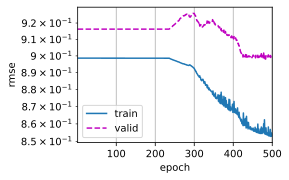

In [15]:
k, num_epochs, lr, weight_decay, batch_size = 5, 500, 0.001, 0.001, 128

train_l, vali_l = k_fold(k,train_features1,train_labels1,num_epochs,lr,
                        weight_decay,batch_size)

In [16]:
sub_data = pd.read_csv('gender_submission.csv')

train rmse 0.863265


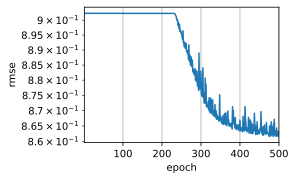

In [17]:
preds = train_and_pred(train_features1,test_features1,train_labels1,sub_data,
                      num_epochs,lr,weight_decay,batch_size)

In [18]:
sub_data['Survived'].mean()

0.7045932

In [19]:
sub_data['Survived'] = [1 if x > 0.7045932 else 0 for x in sub_data['Survived'] ]

In [20]:
sub_data.to_csv('v5/submission_v5.csv',index=False)